In [1]:
#install required packages
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade "transformers>=4.45.0"
!{sys.executable} -m pip install --upgrade requests
!{sys.executable} -m pip install "huggingface-hub<1.0" 
!{sys.executable} -m pip install pandas tqdm openai jsonschema scikit-learn matplotlib seaborn pyarrow

  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.2.1
    Uninstalling huggingface_hub-1.2.1:
      Successfully uninstalled huggingface_hub-1.2.1
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
Using cached tqdm-4.67.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2025.3.2 requires fsspec==2025.3.2.*, but you have fsspec 2025.12.0 which is incompatible.
streamlit 1.45.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.


In [53]:
# Imports
import os
import time
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from jsonschema import validate, ValidationError
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Project Path & Parameters
PROJECT_DIR = "fynd_Assesment"
DATA_DIR = os.path.join(PROJECT_DIR, "data")
RESULTS_DIR = os.path.join(PROJECT_DIR, "results")
PROMPTS_DIR = os.path.join(PROJECT_DIR, "prompts")
NOTEBOOK_DATA_SAMPLE = os.path.join(DATA_DIR, "eval_sample.csv")
FULL_DATA_PATH = os.path.join(DATA_DIR, "yelp_full.csv")  

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PROMPTS_DIR, exist_ok=True)

In [57]:
#CONFIG
CSV_FILENAME = "yelp_full.csv"   
SAMPLE_SIZE = 200

HF_API_URL = f"https://api-inference.huggingface.co/models/{HF_MODEL}"

LLM_TEMPERATURE = 0.0
MAX_TOKENS = 150
PAUSE_BETWEEN_CALLS = 0.2

print("OpenRouter config loaded.")
print("Using model:", LLM_MODEL)

OpenRouter config loaded.
Using model: openrouter/auto


In [56]:
#LLM Settings
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model_local = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype="auto",
)
model_local.eval()
device = torch.device("cpu")
model_local.to(device)
print("Model loaded on", device)

Model loaded on cpu


In [21]:
# Load CSV
df = pd.read_csv(CSV_FILENAME, low_memory=False)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

df = df[['text', 'stars']].dropna()

df['text'] = df['text'].astype(str)
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df = df.dropna(subset=['stars'])

df = df[df['text'].str.len() > 20].copy()

print("Cleaned shape:", df.shape)
df.head(5)

Raw shape: (10000, 10)
Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']
Cleaned shape: (9953, 2)


,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


In [22]:
#eval sample (~200 rows)
SAMPLE_SIZE = 200

unique_stars = sorted(df['stars'].unique())
print("Star ratings available:", unique_stars)

if set([1,2,3,4,5]).issubset(set(unique_stars)):
    per_class = SAMPLE_SIZE // 5
    sample_df = (
        df.groupby('stars', group_keys=False)
          .apply(lambda x: x.sample(min(len(x), per_class), random_state=42))
          .reset_index(drop=True)
    )
else:
    sample_df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print("Sample size:", sample_df.shape)
sample_df.head(5)

Star ratings available: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Sample size: (200, 2)


,text,stars
0,Don't know where I should start. Grand opening...,1
1,Absolutely waste of time & space is this estab...,1
2,I am *floored* that this place has 4 stars. Li...,1
3,Horrible! I had a gel manicure. The tech didn'...,1
4,Not only was the music the worst I have ever h...,1


In [23]:
#Prompt templates
zero_shot = """You are an assistant that classifies Yelp reviews into 1-5 star ratings.

Your task:
- Read the review.
- Decide an integer rating from 1 to 5.
- Explain your choice in one short sentence.

VERY IMPORTANT OUTPUT RULES:
- Return ONLY valid JSON. NO extra text, NO markdown, NO explanation outside JSON.
- JSON must have exactly two keys:
  - "predicted_stars": integer between 1 and 5 (no quotes, no decimals)
  - "explanation": one short sentence string

Correct example:
{"predicted_stars": 5, "explanation": "Very positive review with strong praise."}

Now classify this review:

Review: "<REVIEW_TEXT>"
"""

few_shot_v1 = """You are an assistant that classifies Yelp reviews into 1-5 star ratings.

Follow the examples and mimic the JSON format.

Example 1:
Review: "Food was awful, and the waiter ignored us."
Output: {"predicted_stars": 1, "explanation": "Strong complaints about both food and service."}

Example 2:
Review: "Amazing pizza, super friendly staff, will come again!"
Output: {"predicted_stars": 5, "explanation": "Glowing praise for both food and service."}

Example 3:
Review: "Food was good but service was slow."
Output: {"predicted_stars": 3, "explanation": "Mixed experience with both positives and negatives."}

Now classify the following review.

Output rules:
- Return ONLY valid JSON with keys:
  - "predicted_stars": integer 1-5
  - "explanation": one short sentence

Review: "<REVIEW_TEXT>"
"""

rubric_v1 = """You are an assistant that classifies Yelp reviews into 1-5 star ratings using a rubric.

Rubric:
- 1 star: multiple serious complaints, no clear positives.
- 2 stars: mostly negative, maybe one small positive.
- 3 stars: clearly mixed (positives and negatives).
- 4 stars: mostly positive with only minor issues.
- 5 stars: very positive, strong praise, no major issues.

Your task:
1. Apply the rubric carefully to the review.
2. Decide an integer rating from 1 to 5.
3. Give a one-sentence explanation.

Output rules:
- Return ONLY valid JSON with keys:
  - "predicted_stars": integer 1-5
  - "explanation": one short sentence

Example:
{"predicted_stars": 4, "explanation": "Mostly positive with a minor complaint."}

Now classify this review:

Review: "<REVIEW_TEXT>"
"""

In [43]:
#LLM call function
import requests
import json
import os

import requests, json

def call_llm(prompt: str,
             model=None,              
             temperature: float = 0.0,
             max_tokens: int = 150) -> str:
    messages = [
        {"role": "system", "content": "You are an assistant who returns valid JSON."},
        {"role": "user", "content": prompt},
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    inputs = tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_local.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            do_sample=temperature > 0.0,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated_ids = outputs[0][inputs["input_ids"].shape[-1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return generated_text.strip()

In [44]:
#Dry Run
print(call_llm("Say hello politely in one short sentence."))

Hello! It's nice to meet you.


In [26]:
# Parser & validation
SCHEMA = {
    "type": "object",
    "properties": {
        "predicted_stars": {"type": "integer", "minimum": 1, "maximum": 5},
        "explanation": {"type": "string"}
    },
    "required": ["predicted_stars", "explanation"]
}

def safe_extract_json(raw_text: str):
    if raw_text is None:
        return None
    try:
        start = raw_text.find('{')
        end = raw_text.rfind('}') + 1
        if start == -1 or end == -1:
            return None
        candidate = raw_text[start:end]
        obj = json.loads(candidate)
        return obj
    except Exception:
        try:
            candidate = raw_text.strip().replace("'", '"')
            start = candidate.find('{')
            end = candidate.rfind('}') + 1
            if start == -1 or end == -1:
                return None
            return json.loads(candidate[start:end])
        except Exception:
            return None

def is_valid_schema(obj):
    try:
        validate(instance=obj, schema=SCHEMA)
        return True
    except ValidationError:
        return False

def repair_json(obj):
    if not isinstance(obj, dict):
        return obj
    
    if "predicted_stars" in obj:
        try:
            obj["predicted_stars"] = int(obj["predicted_stars"])
        except Exception:
            mapping = {"one":1, "two":2, "three":3, "four":4, "five":5}
            v = str(obj["predicted_stars"]).lower()
            obj["predicted_stars"] = mapping.get(v, None)

    if obj.get("predicted_stars") is not None:
        if obj["predicted_stars"] < 1: obj["predicted_stars"] = 1
        if obj["predicted_stars"] > 5: obj["predicted_stars"] = 5

    return obj

In [28]:
#Experiment runner
def run_prompt_on_df(prompt_template: str, df_sample: pd.DataFrame, max_rows=None, model=LLM_MODEL):
    records = []
    rows = df_sample if max_rows is None else df_sample.head(max_rows)
    for idx, row in tqdm(rows.iterrows(), total=len(rows), desc="Running prompt"):
        review_text = row['text']
        prompt_text = prompt_template.replace("<REVIEW_TEXT>", review_text)
        start = time.time()
        raw = call_llm(prompt_text, model=model, temperature=LLM_TEMPERATURE, max_tokens=MAX_TOKENS)
        end = time.time()
        parsed = safe_extract_json(raw)
        repaired = None
        valid = False
        stars = None
        explanation = None
        if parsed is not None:
            repaired = repair_json(parsed)
            valid = is_valid_schema(repaired)
            if valid:
                stars = int(repaired["predicted_stars"])
                explanation = repaired["explanation"]
        records.append({
            "index": idx,
            "true_stars": int(row['stars']),
            "raw_output": raw,
            "parsed_json": repaired,
            "json_valid": bool(valid),
            "predicted_stars": stars,
            "explanation": explanation,
            "latency_sec": end-start
        })
        time.sleep(PAUSE_BETWEEN_CALLS)
    return pd.DataFrame(records)

In [29]:
#Dry run (5 rows)
print("Zero-shot test (5 rows):")
zero_test = run_prompt_on_df(zero_shot, sample_df, max_rows=5)
zero_test[['true_stars','predicted_stars','explanation','json_valid']]

Zero-shot test (5 rows):


Running prompt: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.70s/it]


,true_stars,predicted_stars,explanation,json_valid
0,1,1,The review criticizes multiple aspects of the ...,True
1,1,1,The review expresses extreme dissatisfaction w...,True
2,1,1,This review expresses extreme dissatisfaction ...,True
3,1,1,"The review is overwhelmingly negative, critici...",True
4,1,2,The review expresses strong dissatisfaction wi...,True


In [32]:
#Run experiments for three prompts
# ZERO-SHOT
print("Running ZERO-SHOT on all rows...")
zero_results = run_prompt_on_df(zero_shot, sample_df, max_rows=None)
print("Done. Valid JSON rate:", zero_results["json_valid"].mean())

# FEW-SHOT v1 
print("Running FEW-SHOT v1 on all rows...")
few_results = run_prompt_on_df(few_shot_v1, sample_df, max_rows=None)
print("Done. Valid JSON rate:", few_results["json_valid"].mean())

# RUBRIC-based 
print("Running RUBRIC v1 on all rows...")
rub_results = run_prompt_on_df(rubric_v1, sample_df, max_rows=None)
print("Done. Valid JSON rate:", rub_results["json_valid"].mean())

Running ZERO-SHOT on all rows...


Running prompt: 100%|██████████████████████████████████████████████████████████████| 200/200 [1:02:45<00:00, 18.83s/it]


Done. Valid JSON rate: 0.985
Running FEW-SHOT v1 on all rows...


Running prompt: 100%|██████████████████████████████████████████████████████████████| 200/200 [1:03:13<00:00, 18.97s/it]


Done. Valid JSON rate: 0.965
Running RUBRIC v1 on all rows...


Running prompt: 100%|██████████████████████████████████████████████████████████████| 200/200 [1:09:37<00:00, 20.89s/it]

Done. Valid JSON rate: 0.995


In [45]:
#Compute metrics & comparison table
def compute_metrics_df(res_df, name):
    total = len(res_df)
    json_valid_rate = res_df['json_valid'].mean()

    # Only evaluate on rows where JSON was valid and prediction exists
    valid_df = res_df[res_df['json_valid'] == True].dropna(subset=['predicted_stars'])
    if len(valid_df) == 0:
        acc = np.nan
        mae = np.nan
    else:
        acc = (valid_df['predicted_stars'] == valid_df['true_stars']).mean()
        mae = np.abs(valid_df['predicted_stars'] - valid_df['true_stars']).mean()

    avg_latency = res_df["latency_sec"].mean()

    return {
        "prompt": name,
        "total_rows": total,
        "json_valid_rate": json_valid_rate,
        "accuracy_on_valid": acc,
        "mae_on_valid": mae,
        "avg_latency_sec": avg_latency,
    }

In [46]:
summary = pd.DataFrame([
    compute_metrics_df(zero_results, "zero_shot"),
    compute_metrics_df(few_results,  "few_shot_v1"),
    compute_metrics_df(rub_results,  "rubric_v1"),
])

summary

,prompt,total_rows,json_valid_rate,accuracy_on_valid,mae_on_valid,avg_latency_sec
0,zero_shot,200,0.985,0.467005,0.685279,18.620261
1,few_shot_v1,200,0.965,0.336788,1.176166,18.763843
2,rubric_v1,200,0.995,0.497487,0.693467,20.680411


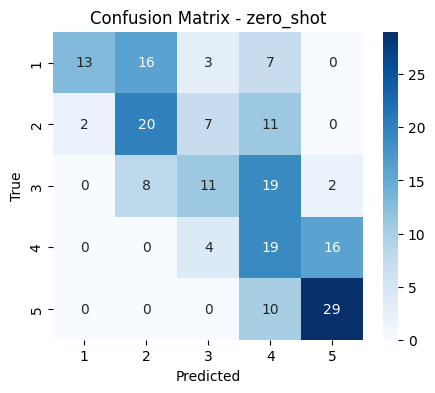

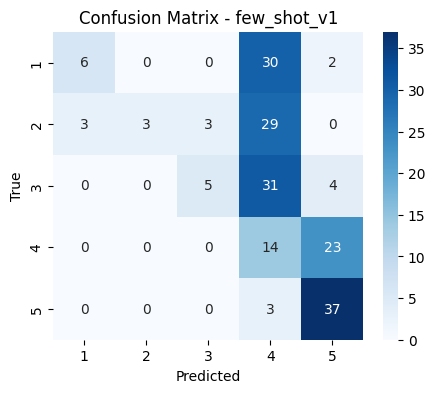

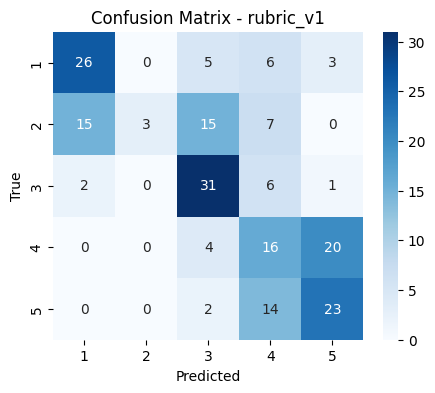

In [47]:
#Confusion matrices & plots
def plot_conf_matrix(res_df, name):
    valid = res_df[res_df['json_valid'] == True].dropna(subset=['predicted_stars'])
    if len(valid) == 0:
        print("No valid JSON for", name)
        return

    cm = confusion_matrix(valid['true_stars'], valid['predicted_stars'], labels=[1,2,3,4,5])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

plot_conf_matrix(zero_results, "zero_shot")
plot_conf_matrix(few_results, "few_shot_v1")
plot_conf_matrix(rub_results, "rubric_v1")

In [52]:
#Save final artifacts
zero_results.to_csv("zero_shot_results.csv", index=False)
few_results.to_csv("few_shot_v1_results.csv", index=False)
rub_results.to_csv("rubric_v1_results.csv", index=False)
summary.to_csv("prompt_comparison_summary.csv", index=False)